# ⭐️Final Project⭐️ 
###### The final projects involve developing programs to analyze and assess the statistical significance of events in scientific data relative to a model. Detailed instructions will be provided on Canvas, and students should expect to begin working on the project starting in the 7th week of the course.

###### Use the following link to make a copy of the Google Document you will use to submit your final (remember to change the sharing permissions):

###### As you create your final project in a Jupyter notebook, you will upload your notebook to GitHub and provide the URL link to the notebook in the Google Doc. You'll submit the URL to the Google Doc as the submission to the assignment (just like with the Code Journals).


###### Final Project Instructions:

###### Steps 1-2 below are preparatory, while Steps 3-5 should appear in the Jupyter notebook uploaded to GitHub.

###### 1) Get astropy and install it on your system (pip install astropy).

###### 2) Get sep and install it on your system (pip install sep).

###### 3) Follow the tutorial found at https://sep.readthedocs.io/en/stable/tutorial.html, but use the astropy fits routines instead of fitsio. Create a notebook that performs the tutorial and comment it using Markdown to explain what it’s doing. Note that the fits image used in the tutorial can be acquired via the sep GitHub account.

###### 4) Augment the tutorial to save each of the four figures to PNG files.

###### 5) Get the f105w band image of the Hubble Ultra Deep Field, which is called: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
###### You can download it from https://archive.stsci.edu/pub/hlsp/hudf12/

###### 6) Redo the tutorial steps in a second notebook, but on the UDF f105w image. How many sources do you find? Histogram their fluxes.

###### 7) What are the mean, median, and standard deviation of the distribution of fluxes. What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? 

###### 8) Download the f125w and f160w images of the HUDF at the same website, and make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.

In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10.0,8.0]

#### First, we'll read an example image from a FITS file and display it, just to show what we're dealing with. The example image used is an official image from a space telescope

In [2]:
# Read image into standard 2-d numpy array
hdulist = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = hdulist[0].data

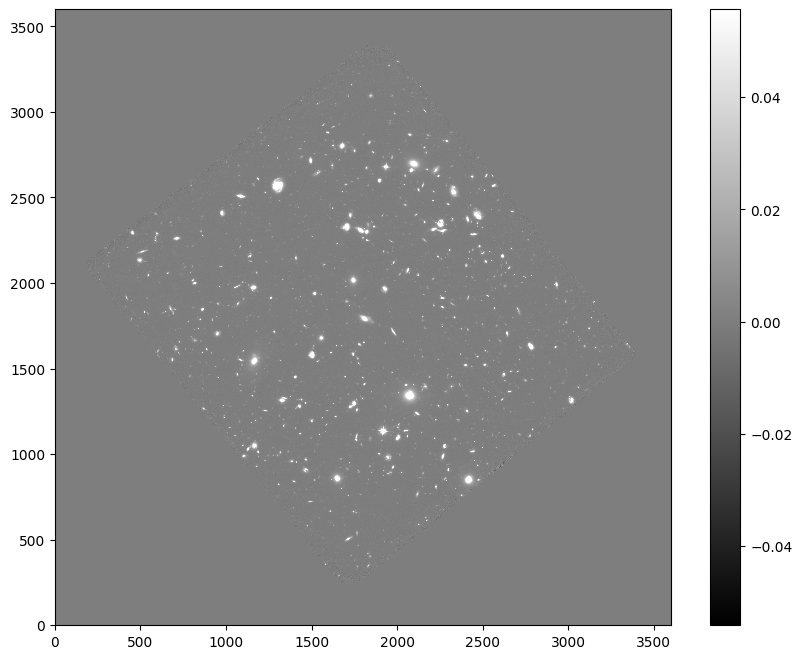

In [3]:
# Show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("f105w_v1.0_drz_RAW.png",bbox_inches='tight',dpi=800) # Save the image as a .png file

## Background Subtraction
#### Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two seperate steps.

In [4]:
# Measure a spatially varying background on the image
data_sep = data.astype(data.dtype.newbyteorder('=')) # Changes the byte order of the array `data` to work with SEP
bkg = sep.Background(data_sep)

##### There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:

In [5]:
# bkg = sep.Background(data_sep, mask=mask, bw=64, bh=64, fw=3, fh=3)

#### This returns a Background object that holds information on spatially varying backgrounds and spatially varying background noise level. We can now do various things with this Background object:

In [6]:
# Get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [7]:
# Evaluate background as 2D array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

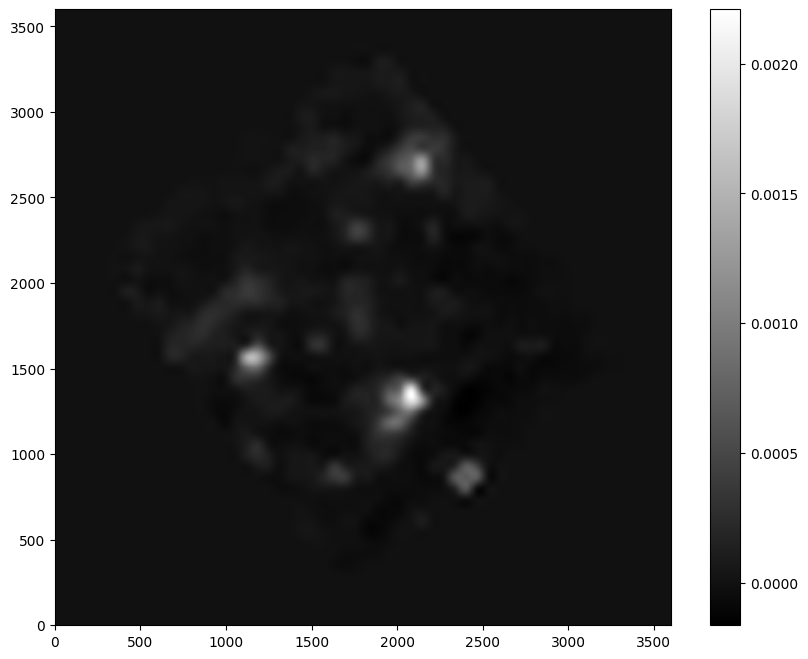

In [8]:
# Show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("f105w_v1.0_drz_BACKGROUND.png",bbox_inches='tight',dpi=800) # Save the image as a .png file

In [9]:
# Evaluate the background noize as a 2D array, same size as the original image
bkg_rms = bkg.rms()

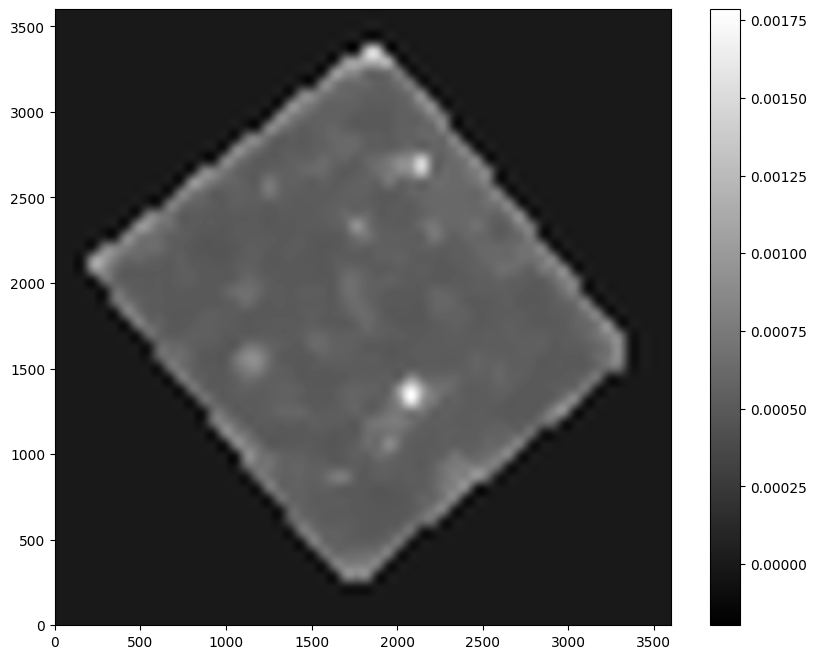

In [10]:
# Show the background noise as an image
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("f105w_v1.0_drz_BKGNOISE.png", bbox_inches='tight',dpi=800) # Save the image as a .png file

In [11]:
# Subtract the background
data_sub = data - bkg

#### One can also subtract the background from the data array in-place by doing bkg.subfrom(data)

## Object Detection
#### Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of 1.5sigma where sigma is the global background RMS.

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

#### objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detection objects are, we'll over-plot the object coordinates with some basic shape parameters on the image:

TypeError: list.append() takes no keyword arguments

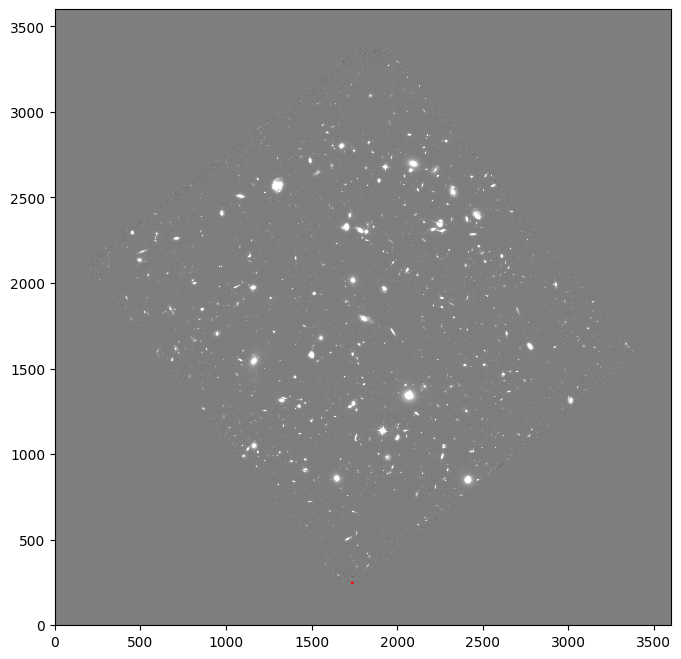

In [13]:
from matplotlib.patches import Ellipse

# Plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Create an empty array for the x coordinates of the ellipses
ec = []

# Plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    ec.append(x=objects['x'][i]) #######################################################
    
plt.savefig("f105w_v1.0_drz_OBJECTS.png", bbox_inches='tight',dpi=800) # Save the image as a .png file

#### objects has many other fields, giving information such as second moments, and peak pixel positions and values. You can see the available fields:

In [14]:
# Available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry
#### Finally we'll perform circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [15]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

#### flux, fluxerr, and flag are all 1D arrays with one entry per object.

In [16]:
# Show the first 10 object results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


## Histogram
#### Now we'll set up a histogram that displays the spread of the objects detected

In [17]:
# Create the histogram bins
width = 0.1
histmin = np.floor(min(ec))
histmax = np.ceil(max(ec))+width

ValueError: min() iterable argument is empty